## Supplementary figure of GO predictions

Panels:

- a) Examples of good predictions
- b) Examples of poor predictions
- c) Scatter plot of Cell Painting vs. L1000
- d) Performance summary

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "go_prediction_supplement")
extensions <- c(".png", ".pdf")

In [3]:
dl_go_targets <- c(
    "GO:0030182" = "Neuron differentation\n(GO:0030182)",
    "GO:0006325" = "Chromatin organization\n(GO:0006325)",
    "GO:1990239" = "Steroid hormone binding\n(GO:1990239)",
    "GO:0004714" = "Transmembrane RTK activity\n(GO:0004714)",
    "GO:1900087" = "+Reg of G1/S\n(GO:1900087)",
    "GO:0071277" = "Response to CA+2\n(GO:0071277)"
)

metric_dir <- file.path("..", "2.MOA-prediction", "metrics")
performance_dir <- file.path("../2.MOA-prediction/4.model_viz/performance_results")

In [4]:
# Load average precision scores for all models and targets
ap_file <- file.path(metric_dir, "average_precision_full_results.tsv.gz")

ap_cols <- readr::cols(
  average_precision = readr::col_double(),
  target = readr::col_character(),
  assay = readr::col_character(),
  model = readr::col_character(),
  shuffle = readr::col_logical(),
  data_split = readr::col_character(),
  target_category = readr::col_character()
)

ap_df <- readr::read_tsv(ap_file, col_types = ap_cols)

print(dim(ap_df))
head(ap_df, 2)

[1] 48547     9


average_precision,target,assay,model,shuffle,data_split,subsample_status,target_category,n_pos_count
<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<dbl>
0.0009466525,11-beta hydroxysteroid dehydrogenase inhibitor,cp,mlknn,TRUE,train,TRUE,moa,17
0.0009980768,11-beta-hsd1 inhibitor,cp,mlknn,TRUE,train,TRUE,moa,18


## Panel A - Good predictions

In [5]:
# Load data for visualization
targets_list <- list(
    "panel_a" = c("GO:0030182", "GO:0006325", "GO:1990239"),
    "panel_b" = c("GO:0004714", "GO:1900087", "GO:0071277")
)

results_dir <- file.path("..", "2.MOA-prediction", "metrics", "pr_curves")
results_prefix <- "precision_recall_curve__"
results_suffix <- ".tsv.gz"
plot_category <- "main"

pr_pathway_df <- list()
for (panel in names(targets_list)) {
    pr_pathway_df[[panel]] <- list()
    focus_targets <- targets_list[[panel]]
    for (target in focus_targets) {
        
        # Load precision recall curves
        pr_temp_df <- process_pr_deeplearning_data(
            target = target,
            results_dir = results_dir,
            results_prefix = results_prefix,
            results_suffix = results_suffix,
            plot_category = plot_category
        )
        
        # Reorder model factor
        pr_temp_df$model <- factor(pr_temp_df$model, levels = names(model_names))
        
        # Recode and reorder compound names
        pr_temp_df$target <- factor(pr_temp_df$target, levels = focus_targets)
        pr_temp_df$target <- dplyr::recode_factor(pr_temp_df$target, !!!dl_go_targets)
        
        # Store in list
        pr_pathway_df[[panel]][[target]] <- pr_temp_df
    }
    pr_pathway_df[[panel]] <- dplyr::bind_rows(pr_pathway_df[[panel]])
}

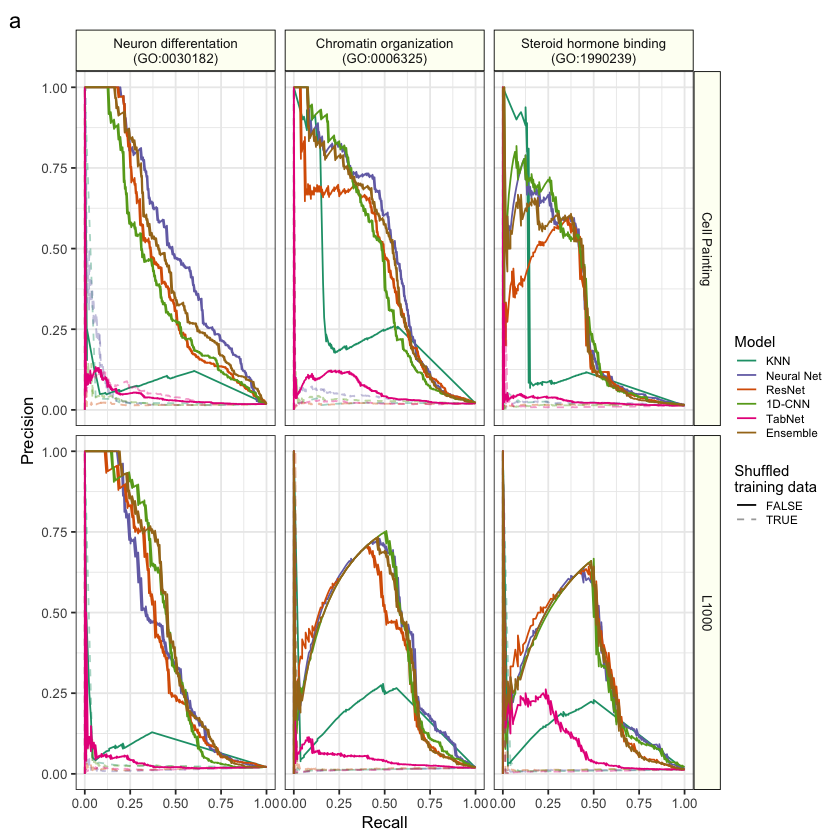

In [6]:
panel_a_gg <- (
    ggplot(pr_pathway_df[["panel_a"]], aes(x = recall_round, y = precision_round))
    + geom_line(aes(color = model, linetype = data_shuffle, alpha = data_shuffle))
    + facet_grid("assay~target")
    + figure_theme
    + xlab("Recall")
    + ylab("Precision")
    + scale_color_manual(name = "Model", labels = model_names, values = model_colors)
    + scale_linetype_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_linetypes)
    + scale_alpha_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_alphas)
    + guides(
        color = guide_legend(order = 1),
        linetype = guide_legend(order = 2),
        alpha = guide_legend(order = 2)
    )
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.6, "lines"),
        legend.key.width = unit(1, "lines")
    )
    + labs(tag = "a")
)

panel_a_gg

## Panel B - Poor predictions

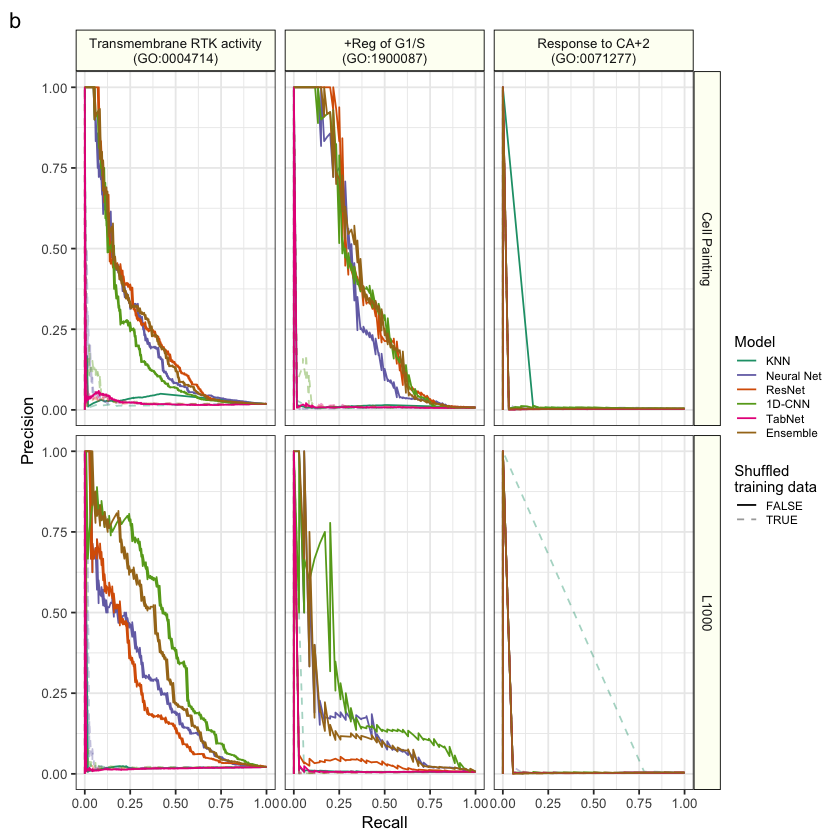

In [7]:
panel_b_gg <- (
    ggplot(pr_pathway_df[["panel_b"]], aes(x = recall_round, y = precision_round))
    + geom_line(aes(color = model, linetype = data_shuffle, alpha = data_shuffle))
    + facet_grid("assay~target")
    + figure_theme
    + xlab("Recall")
    + ylab("Precision")
    + scale_color_manual(name = "Model", labels = model_names, values = model_colors)
    + scale_linetype_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_linetypes)
    + scale_alpha_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_alphas)
    + guides(
        color = guide_legend(order = 1),
        linetype = guide_legend(order = 2),
        alpha = guide_legend(order = 2)
    )
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.6, "lines"),
        legend.key.width = unit(1, "lines")
    )
    + labs(tag = "b")
)

panel_b_gg

## Panel C - Scatterplot

In [8]:
ap_go_compliment_df <- ap_df %>%
    dplyr::group_by(assay, target) %>%
    dplyr::filter(
        target_category == "go",
        data_split == "test",
        !shuffle
    ) %>%
    dplyr::top_n(n = 1, wt = average_precision) %>%
    tidyr::drop_na()


ap_go_data <- ap_go_compliment_df %>%
    reshape2::dcast(
        target ~ assay,
        value.var = "average_precision"
    )

ap_go_count <- ap_go_compliment_df %>%
    reshape2::dcast(
        target ~ assay,
        value.var = "n_pos_count"
    )

ap_go_compliment_df <- ap_go_data %>%
    dplyr::left_join(
        ap_go_count, by = "target", suffix = c("", "_n_pos_count")
    ) %>%
    dplyr::mutate(aupr_total = cp + L1000) %>%
    dplyr::arrange(desc(aupr_total)) %>%
    # Remove targets with very high pos counts to reduce inflated results
    dplyr::filter(L1000_n_pos_count < 1000)

print(dim(ap_go_compliment_df))
head(ap_go_compliment_df, 10)

[1] 761   6


,target,cp,L1000,cp_n_pos_count,L1000_n_pos_count,aupr_total
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GO:0030182,0.5259472,0.4653402,168,119,0.9912874
2,GO:0006325,0.4994475,0.4128435,180,108,0.9122910
3,GO:0001046,0.4401502,0.3573847,210,126,0.7975349
4,GO:0071560,0.3912847,0.3197672,240,144,0.7110519
5,GO:0042475,0.3307410,0.3733057,120,72,0.7040467
6,GO:0051879,0.3820260,0.3143081,204,131,0.6963341
7,GO:0004714,0.2513136,0.4114564,168,119,0.6627700
8,GO:1990239,0.3359924,0.3250931,120,72,0.6610855
9,GO:0018108,0.2537005,0.4002091,168,119,0.6539096


In [9]:
# Test the correlation between the two assays
cor.test(ap_go_compliment_df$cp, ap_go_compliment_df$L1000, method = "spearman")


	Spearman's rank correlation rho

data:  ap_go_compliment_df$cp and ap_go_compliment_df$L1000
S = 6187900, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9157555 


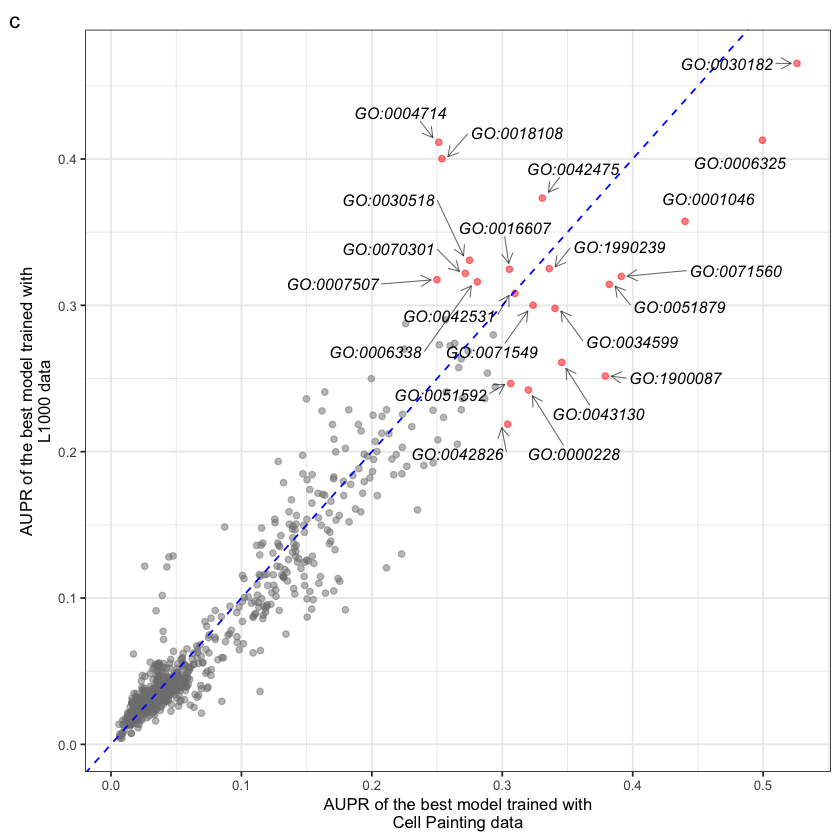

In [10]:
color_logic <- ap_go_compliment_df$cp > 0.3 | ap_go_compliment_df$L1000 > 0.3

panel_c_gg <- (
    ggplot(ap_go_compliment_df, aes(y = L1000, x = cp))
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.5)
    + figure_theme
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "blue")
    + xlab("AUPR of the best model trained with\nCell Painting data")
    + ylab("AUPR of the best model trained with\nL1000 data")
    + geom_text_repel(
        data = subset(ap_go_compliment_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.3,
        segment.alpha = 0.6,
        size = 3.4,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.5,
        aes(
            x = cp,
            y = L1000,
            label = target,
        )
    )
    + labs(tag = "c")
)

panel_c_gg

## Panel D - GO summary performance

In [11]:
# Load metrics results
metrics_file <- file.path(performance_dir, "all_pathway_performance_metrics.csv")

metrics_cols <- readr::cols(
    id_name = readr::col_character(),
    metrics = readr::col_character(),
    values = readr::col_double(),
    profile_tech = readr::col_character(),
    model = readr::col_character(),
    shuffle = readr::col_logical()
)

all_path_metrics_df <- readr::read_csv(metrics_file, col_types = metrics_cols) %>%
    dplyr::mutate(updated_metric = values / 100)

# Process data
all_path_metrics_df$profile_tech <- dplyr::recode(
    all_path_metrics_df$profile_tech,
    `Cell painting` = "Cell Painting",
    `Cell painting subsample` = "Cell Painting (subsample)"
)
all_path_metrics_df$metrics <- dplyr::recode(
    all_path_metrics_df$metrics, `Precision-Recall_AUC` = "Precision-recall", `ROC_AUC` = "ROC"
)
all_path_metrics_df$metrics <- factor(all_path_metrics_df$metrics, levels = c("ROC", "Precision-recall"))
all_path_metrics_df$model <- factor(
    all_path_metrics_df$model,
    levels = c("Ml-KNN", "Simple NN", "ResNet", "1D-CNN", "TabNet", "Models Ensemble")
)
all_path_metrics_df$model <- dplyr::recode(
    all_path_metrics_df$model, `Models Ensemble` = "Ensemble", "Ml-KNN" = "KNN", "Simple NN" = "Neural Net" 
)

head(all_path_metrics_df)

id_name,metrics,values,profile_tech,model,shuffle,updated_metric
<chr>,<fct>,<dbl>,<chr>,<fct>,<lgl>,<dbl>
CP_mlknn,Precision-recall,9.100655,Cell Painting,KNN,FALSE,0.09100655
CP_resnet,Precision-recall,13.203887,Cell Painting,ResNet,FALSE,0.13203887
CP_cnn,Precision-recall,12.185388,Cell Painting,1D-CNN,FALSE,0.12185388
CP_tabnet,Precision-recall,10.527334,Cell Painting,TabNet,FALSE,0.10527334
CP_simplenn,Precision-recall,12.642642,Cell Painting,Neural Net,FALSE,0.12642642
CP_blend,Precision-recall,13.906303,Cell Painting,Ensemble,FALSE,0.13906303


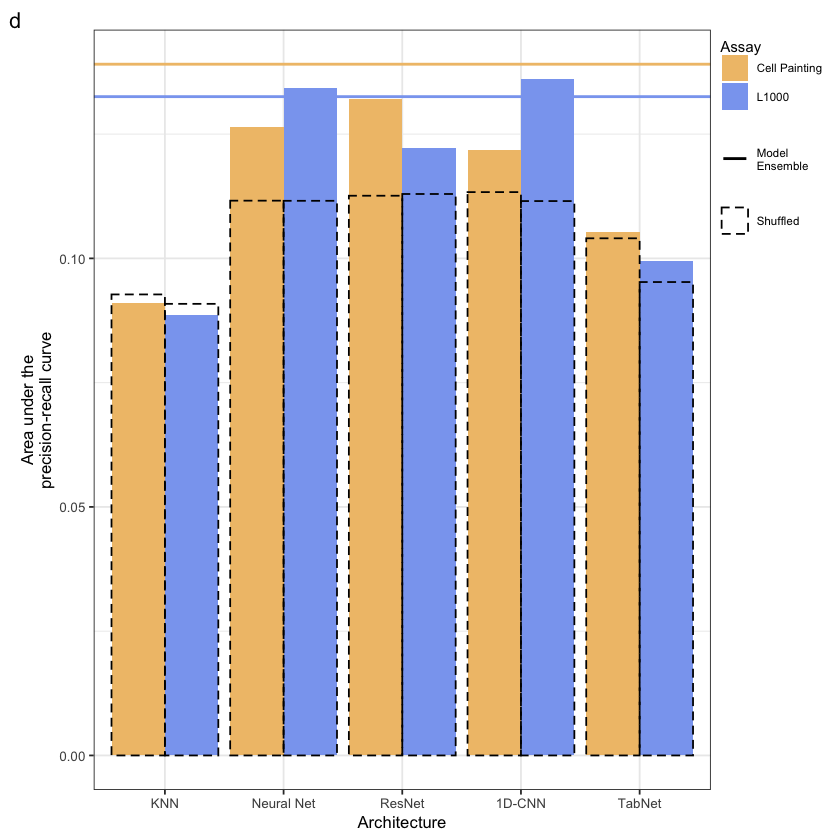

In [12]:
panel_d_df <- all_path_metrics_df %>%
    dplyr::filter(profile_tech %in% c("Cell Painting", "L1000")) %>%
    dplyr::filter(metrics == 'Precision-recall')

ensemble_df <- panel_d_df %>%
    dplyr::filter(model == "Ensemble")

panel_d_df <- panel_d_df %>%
    dplyr::filter(model != "Ensemble")

panel_d_gg <- (
    ggplot(data = NULL, aes(x = model, y = updated_metric))
    + geom_bar(
        data = panel_d_df %>% dplyr::filter(!shuffle),
        stat = "identity",
        aes(fill = profile_tech),
        position = "dodge"
    )
    + geom_bar(
        data = panel_d_df %>% dplyr::filter(shuffle),
        stat = "identity",
        aes(color = profile_tech),
        alpha = 0,
        position = "dodge",
        linetype = "dashed"
    )
    + figure_theme
    + theme(
        legend.spacing.y = unit(0.01, "cm"),
        legend.box.spacing = unit(0.01, "cm"),
        legend.justification = "top"
    )
    + scale_fill_manual("Assay", values = assay_colors)
    + scale_color_manual(breaks = "Cell Painting", name = "", values = c("black", "black"), labels = c("Shuffled"))
    + scale_linetype_manual(name = "", values = "solid", labels = "Model\nEnsemble")
    + geom_hline(data = ensemble_df, aes(yintercept = updated_metric, linetype = "Ensemble"), color = paste(assay_colors), lwd = 0.8)    
    + xlab("Architecture")
    + ylab("Area under the\nprecision-recall curve")
    + guides(
        fill = guide_legend(order = 1),
        color = guide_legend(order = 3),
        linetype = guide_legend(order = 2)
    )
    + labs(tag = "d")
)

panel_d_gg

## Compile supplementary figure

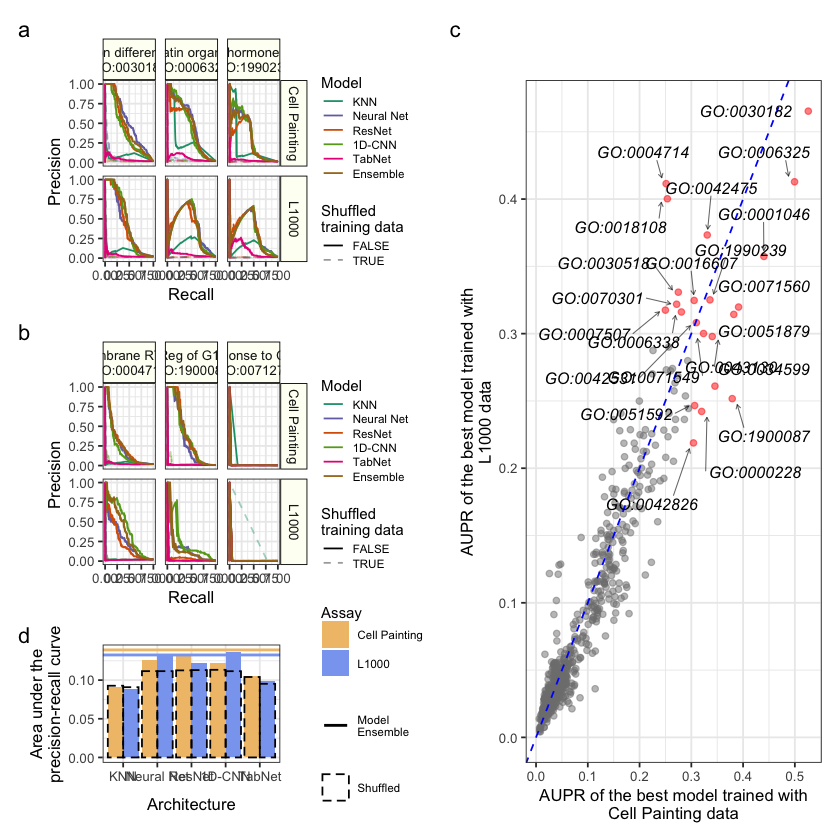

In [13]:
sup_fig_gg <- (
    (
        panel_a_gg /
        panel_b_gg /
        panel_d_gg
    ) + plot_layout(heights = c(1, 1, 0.65)) | panel_c_gg
) + plot_layout(widths = c(0.6, 1))

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, sup_fig_gg, height = 9.5, width = 15.5, dpi = 500)
}

sup_fig_gg